# Graph Neural Networks versus Simulated Annealing for Max-Cut

#### Author: Ivan Carvalho (@IvanIsCoding)

<a href="https://colab.research.google.com/github/IvanIsCoding/GNN-for-Combinatorial-Optimization/blob/main/01_GNN_vs_SA_for_Max_Cut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In the previous notebook, we defined the architecture to use Graph Neural Networks to solve Combinatorial Optimization problems.

In  this is notebbok, we will benchmark the quality of the solutions from our Graph Neural Networks against solutions obtained via Simulated Annealing (SA). Simulated Annealing is a common technique used to approximate QUBO solutions. We focus on the Max-Cut solutions first.

Our benchmark is partly inspired by [Inability of a graph neural network heuristic to outperform greedy algorithms in solving combinatorial optimization problems like Max-Cut
](https://arxiv.org/abs/2210.00623) by Boettcher. In his work, Boettcher argues that the GNNs can be outperformed by simple greedy algorithms and argues that Schuetz et al. overlooked trivial baselines when comparing the GNN results. Instead of implementing the greedy algorithm mentioned in Boettcher, I felt it would be more interesting to apply SA. SA is a general technique for QUBOs while the greedy algorithm is tailored for the Max-Cut problem.

So let's get started! Firstly, we will install the `gnn_for_co` library we defined thanks to nbdev. That will allow us to reuse all the functions from our initial notebook.

In [ ]:
!pip install -q git+https://github.com/IvanIsCoding/GNN-for-Combinatorial-Optimization.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.4/197.4 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.8/244.8 KB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.1/238.1 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 118.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 97.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 95.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 KB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 115.8 MB/s eta

Note that this notebook will also export some functions we will use in the third notebook. Don't worry about the cryptic comments too much, they are just nbdev directives.

In [ ]:
# | default_exp train

In [ ]:
# | export
from gnn_for_co.core import (
    create_train_state,
    train_step,
    get_classification,
    create_Q_matrix,
    create_max_cut_model,
    create_mis_model,
)

import jax
import jax.numpy as jnp
import numpy as np
import networkx as nx
import openjij as oj
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import trange, tqdm

sns.set_theme()

## Solving a QUBO instance using OpenJij's Simulated Annealing sampler

Our baseline will be Simulated Annealing. More specifically, it will be [OpenJij](https://openjij.github.io/OpenJij)'s implementation of simulated annealing, the [SASampler](https://openjij.github.io/OpenJij/reference/openjij/sampler/sa_sampler/index.html).

A very brief description of Simulated Annealing is that is a stochastic optimization process. SA generates candidate solutions $x_{1} \rightarrow x_{2} \ldots \rightarrow x_{k}$ throughout its process. At each step, the algorithm uses randomness to generate a new $x^{\prime}$. After, it either accepts the new value, $x_{i} = x^{\prime}$, or rejects it, $x_{i} = x_{i-1}$, using the Metropolis-Hastings algorithm. The probabilities of the Metropolis-Hastings depend on the temperature $T_{i}$, which is annealed throughout the algorithm. Hence the name Simulated Annealing.

The interface we will be using for this sampler shared among other samplers. It works by feeding a QUBO dict to the sampler and then performing a number of reads. Some other samplers that you might want to try to use are:
* [D-wave's Neal Sampler](https://docs.ocean.dwavesys.com/projects/neal/en/latest/reference/sampler.html) - another implementation of simulated annealing
* [D-Wave's Ocean Sampler](https://docs.ocean.dwavesys.com/en/stable/docs_system/reference/samplers.html#dwave.system.samplers.DWaveSampler) - runs on special quantum annealing hardware by D-Wave tailored to solve QUBO/Ising problems
* [OpenJij's SQASampler](https://openjij.github.io/OpenJij/reference/openjij/sampler/sqa_sampler/index.html) - implementation of simulated quantum annealing also by OpenJij

To demonstrate SA in practice, we reuse the same random graph from the previous notebook. We visualize the graph, then instantiate the SASampler. We feed the QUBO dictionary to the sample and retrieve the best solution the sampler found.

In [ ]:
G = nx.convert_node_labels_to_integers(
    nx.fast_gnp_random_graph(n=100, p=0.05, seed=2023)
)

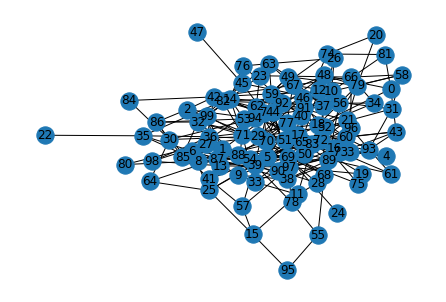

In [ ]:
nx.draw(G, pos=nx.spring_layout(G, seed=2023), with_labels=True)

In [ ]:
sampler = oj.SASampler()

In [ ]:
model = create_max_cut_model(G)
qubo_dict, offset = model.to_qubo()

In [ ]:
response = sampler.sample_qubo(qubo_dict, num_reads=1000)

In [ ]:
response.first.energy

-213.0

In [ ]:
node_color = ["lightblue" for i in range(G.number_of_nodes())]
for x, val in response.first.sample.items():
    if val == 1:
        node_color[int(x[2:-1])] = "yellow"

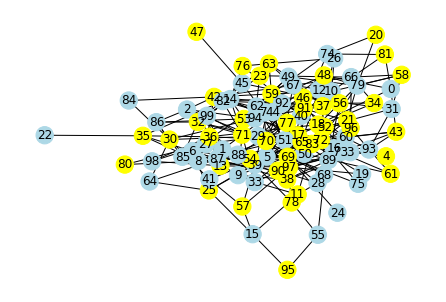

In [ ]:
nx.draw(G, pos=nx.spring_layout(G, seed=2023), node_color=node_color, with_labels=True)

Our SASampler seems to be working and it found a Max-Cut of 213 on the graph.

## Training GNNs and Sampling with Simulated Annealing


Now that we know how to obtain solution to QUBO problems using both GNNs and SA, we write some code to automate the process for us.

`solve_with_gnn` creates a Graph Neural Network and trains it using JAX + Flax. It is possible that sometimes the GNN will find clearly sub-optimal solutons (e.g. Max-Cut of zero). Hence, we add an option to re-run the GNN with a different seed up a couple times. In the paper by Schuetz et al., the authors report that 5 shots were enough.

`solve_with_annealing` calls the SASampler from OpenJij. It is a short functiod and we keep the default parameters from OpenJij.

In [ ]:
# | export
def inner_solve_with_gnn(
    G,
    embedding_size,
    hidden_size,
    learning_rate,
    epochs,
    dropout_rate,
    seed=2023,
    verbose=False,
    is_max_cut=True,
):
    A = jnp.array(nx.to_numpy_array(G))
    Q = create_Q_matrix(G, is_max_cut=is_max_cut)

    rng = jax.random.PRNGKey(seed)
    rng, init_rng = jax.random.split(rng)
    rng, embed_rng = jax.random.split(rng)
    state = create_train_state(
        G.number_of_nodes(),
        embedding_size,
        hidden_size,
        init_rng,
        learning_rate,
        dropout_frac=0.01,
    )
    node_embeddings = jax.random.uniform(embed_rng, [G.number_of_nodes(), embedding_size])

    for epoch in trange(1, epochs + 1, disable=not verbose):
        rng, dropout_rng = jax.random.split(rng)
        state, metrics = train_step(
            state=state,
            node_embeddings=node_embeddings,
            adj_matrix=A,
            q_matrix=Q,
            dropout_rng=dropout_rng,
        )

        if epoch % 25 == 0 and verbose:
            print("train epoch: %d, cost: %.2f" % (epoch, metrics["energy"]))

    classification = np.array(
        get_classification(state.apply_fn, state.params, node_embeddings, A)
    )
    probs = state.apply_fn({"params": state.params}, node_embeddings, A)
    solution = {f"X[{i}]": classification[i] for i in range(G.number_of_nodes())}
    last_energy = metrics["energy"]

    return {
        "classification": classification,
        "probs": probs,
        "energy": last_energy,
        "solution": solution,
    }


def solve_with_gnn(
    G,
    embedding_size,
    hidden_size,
    learning_rate,
    epochs,
    dropout_rate,
    seed=2023,
    verbose=False,
    shots=5,
    is_max_cut=True,
):
    lower_bound = -G.number_of_nodes() / 10.0

    for k in range(shots):
        solution = inner_solve_with_gnn(
            G,
            embedding_size,
            hidden_size,
            learning_rate,
            epochs,
            dropout_rate,
            seed + (k + 1) ** 3,
            verbose,
            is_max_cut,
        )

        if solution["energy"] <= lower_bound:
            break

    return solution

In [ ]:
# | export
def solve_with_annealing(G, num_reads, is_max_cut=True):
    sampler = oj.SASampler()

    if is_max_cut:
        model = create_max_cut_model(G)
    else:
        model = create_mis_model(G)

    qubo_dict, offset = model.to_qubo()

    response = sampler.sample_qubo(qubo_dict, num_reads=num_reads)

    return {
        "sample": response.first.sample,
        "energy": response.first.energy,
        "model": model,
    }

## Max-Cut for d-Regular Graphs (d = 3)

With the solvers in hands, it is time to pitch GNNs against SA. We compare them on a benchmark of d-Regular Graps with d = 3. This was one of the types of graph used by Schuetz et al. on their original paper. d-Regular graphs are graphs in which every vertex has the same number of neighbors. Hence, we generate random instances where every vertex has 3 neighbors.

For all instances, Schuetz et al. managed to beat their baseline. Let's check if this is what happens on this case too. We will run the code for graphs ranging from 100 to 2000 nodes and plot the Max-Cut value in a graph.

In [ ]:
d3_graphs = {
    i: nx.convert_node_labels_to_integers(nx.random_regular_graph(d=3, n=i, seed=2023))
    for i in range(100, 2100, 100)
}

In [ ]:
df = pd.DataFrame(columns=["N", "Max-Cut Size", "Algorithm"])
gnn_results = []
sa_results = []

In [ ]:
for i, G in tqdm(d3_graphs.items()):

    annealing_sol = solve_with_annealing(G, num_reads=2000)
    model = annealing_sol["model"]
    sa_results.append(-annealing_sol["energy"])

    print(f"N = {i}, Anneling found {sa_results[-1]}")

    embedding_d0 = int(np.sqrt(i))
    embedding_d1 = embedding_d0 // 2
    learning_rate = 0.005
    epochs = 10000
    if i < 1400:
        dropout_rate = 0.01
    else:
        dropout_rate = 0.05
    gnn_sol = solve_with_gnn(
        G,
        embedding_d0,
        embedding_d1,
        learning_rate,
        epochs,
        dropout_rate,
        seed=2023,
        verbose=False,
    )

    gnn_results.append(
        -model.decode_sample(gnn_sol["solution"], vartype="BINARY").energy
    )
    print(f"N = {i}, Graph Neural Networks found {gnn_results[-1]}")

  0%|          | 0/20 [00:00<?, ?it/s]

N = 100, Anneling found 138.0
N = 100, Graph Neural Networks found 122.0
N = 200, Anneling found 275.0
N = 200, Graph Neural Networks found 241.0
N = 300, Anneling found 413.0
N = 300, Graph Neural Networks found 360.0
N = 400, Anneling found 551.0
N = 400, Graph Neural Networks found 490.0
N = 500, Anneling found 689.0
N = 500, Graph Neural Networks found 602.0
N = 600, Anneling found 828.0
N = 600, Graph Neural Networks found 727.0
N = 700, Anneling found 965.0
N = 700, Graph Neural Networks found 844.0
N = 800, Anneling found 1103.0
N = 800, Graph Neural Networks found 961.0
N = 900, Anneling found 1242.0
N = 900, Graph Neural Networks found 1085.0
N = 1000, Anneling found 1381.0
N = 1000, Graph Neural Networks found 1190.0
N = 1100, Anneling found 1518.0
N = 1100, Graph Neural Networks found 1345.0
N = 1200, Anneling found 1657.0
N = 1200, Graph Neural Networks found 1469.0
N = 1300, Anneling found 1791.0
N = 1300, Graph Neural Networks found 1567.0
N = 1400, Anneling found 1935.0


In [ ]:
for n, cut_size in zip(range(100, 2100, 100), gnn_results):
    df.loc[len(df)] = [n, cut_size, "Graph Neural Network"]

In [ ]:
for n, cut_size in zip(range(100, 2100, 100), sa_results):
    df.loc[len(df)] = [n, cut_size, "Simulated Annealing"]

[]

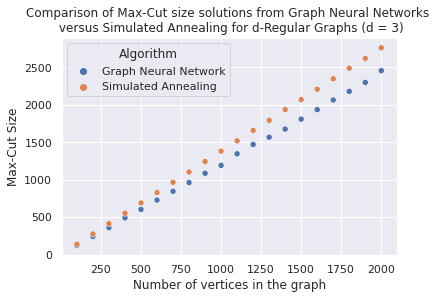

In [ ]:
sns.scatterplot(data=df, x="N", y="Max-Cut Size", hue="Algorithm").set(
    title="Comparison of Max-Cut size solutions from Graph Neural Networks \n versus Simulated Annealing for d-Regular Graphs (d = 3)",
    ylabel="Max-Cut Size",
    xlabel="Number of vertices in the graph",
)
plt.plot()

As we can see above, GNNs did NOT come on top! This shows us that there are potential improvements that can be made to the GNN to improve the quality of its solution.

The results are not necessarily bad. It is still neat that a GNN can approximat the solution with gaps between 10 to 20% of SA. Nevertheless, GNN might not be the silver bullet promised in the paper. In this point, our results agree with Boettcher that the baseline used by Schuetz et al. was weak.

## Max-Cut for d-Regular Graphs (d = 5)

We also benchmark GNN vs SA on d-Regular graphs for d = 5. The comparison for d=5 is also present in the paper by Schuetz et al. The authors also claim that GNN beats their baseline on this type of graph. 

The topolgy of the graph could affect the performance for both algorithms. Thus it is worthwhile to compare on this type of graph too and see the gaps between the algorithms.

In [ ]:
d5_graphs = {
    i: nx.convert_node_labels_to_integers(nx.random_regular_graph(d=5, n=i, seed=2023))
    for i in range(100, 2100, 100)
}

In [ ]:
df = pd.DataFrame(columns=["N", "Max-Cut Size", "Algorithm"])
gnn_results = []
sa_results = []

In [ ]:
for i, G in tqdm(d5_graphs.items()):

    annealing_sol = solve_with_annealing(G, num_reads=2000)
    model = annealing_sol["model"]
    sa_results.append(-annealing_sol["energy"])

    print(f"N = {i}, Anneling found {sa_results[-1]}")

    embedding_d0 = int(np.sqrt(i))
    embedding_d1 = embedding_d0 // 2
    learning_rate = 0.005
    epochs = 10000
    if i < 1400:
        dropout_rate = 0.01
    else:
        dropout_rate = 0.05
    gnn_sol = solve_with_gnn(
        G,
        embedding_d0,
        embedding_d1,
        learning_rate,
        epochs,
        dropout_rate,
        seed=2023,
        verbose=False,
    )

    gnn_results.append(
        -model.decode_sample(gnn_sol["solution"], vartype="BINARY").energy
    )
    print(f"N = {i}, Graph Neural Networks found {gnn_results[-1]}")

  0%|          | 0/20 [00:00<?, ?it/s]

N = 100, Anneling found 205.0
N = 100, Graph Neural Networks found 189.0
N = 200, Anneling found 411.0
N = 200, Graph Neural Networks found 371.0
N = 300, Anneling found 623.0
N = 300, Graph Neural Networks found 562.0
N = 400, Anneling found 829.0
N = 400, Graph Neural Networks found 739.0
N = 500, Anneling found 1039.0
N = 500, Graph Neural Networks found 904.0
N = 600, Anneling found 1244.0
N = 600, Graph Neural Networks found 1104.0
N = 700, Anneling found 1455.0
N = 700, Graph Neural Networks found 1269.0
N = 800, Anneling found 1661.0
N = 800, Graph Neural Networks found 1471.0
N = 900, Anneling found 1871.0
N = 900, Graph Neural Networks found 1659.0
N = 1000, Anneling found 2081.0
N = 1000, Graph Neural Networks found 1833.0
N = 1100, Anneling found 2285.0
N = 1100, Graph Neural Networks found 2027.0
N = 1200, Anneling found 2492.0
N = 1200, Graph Neural Networks found 2209.0
N = 1300, Anneling found 2709.0
N = 1300, Graph Neural Networks found 2371.0
N = 1400, Anneling found 2

In [ ]:
for n, cut_size in zip(range(100, 2100, 100), gnn_results):
    df.loc[len(df)] = [n, cut_size, "Graph Neural Network"]

In [ ]:
for n, cut_size in zip(range(100, 2100, 100), sa_results):
    df.loc[len(df)] = [n, cut_size, "Simulated Annealing"]

[]

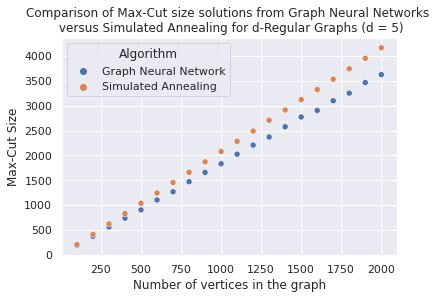

In [ ]:
sns.scatterplot(data=df, x="N", y="Max-Cut Size", hue="Algorithm").set(
    title="Comparison of Max-Cut size solutions from Graph Neural Networks \n versus Simulated Annealing for d-Regular Graphs (d = 5)",
    ylabel="Max-Cut Size",
    xlabel="Number of vertices in the graph",
)
plt.plot()

The results put again SA at the top and GNNs at the bottom. The argument by Boettcher becomes stronger. Boettcher managed to beat the results by Schuetz et al. with a greedy algorithm. We also managed to beat them with a completely differnt baseline that was SA. This puts two algorithms ahead of GNN, while in the paper there are none.

## Discussion

We can discuss pros and cons of the GNN architecture in the following bullet points. It is important to highlight the achievements of Schuetz et al. But we can incorporate some criticism as did Boettcher.

### Pros
* Schuetz et al. proposed a new architecture that solves QUBO instances via unsupervised learning; this is remarkable; it is not straightforward how to approximate the solutions with gradient descent but the authors did it
* Schuetz et al. solved large QUBO instances with up to $10^{6}$ nodes. We did not attempt to reproduce those specific results, but it is neat that the authors managed to train a  GNN on such large instances. Many solvers struggle with large instances, which was not the case for GNNs
* There is room for improvement on the GNN architecture. We can improve the number of layers, the type of layer (e.g. use Graph Attention or other layers), and even tweak the smoothing of the cost function. So in terms of future work, Schuetz et al. is promising.

### Cons

* The current architecture of the GNN is not enough to solve the problems. The $k$-Hop neighbourhood for $k = 2$ and $k = 3$ does not capture the whole story and the GNN finds sub-optimal approximations.
* The baselines in the paper were not adequate. This undermines the work by the authors. Even if GNNs are relevant, they are not the best. This needs to be clear.
* Sometimes the GNN gets stuck on solutions with cost $0$. The authors handle them by running the GNN again with a different seed. This works, but is a sign that maybe the cost landscape for the problem is more challenging than they thought.

# Maximum Independent Set instances

After checking the results for the Max-Cut, let's jump into the MIS results of GNN vs Simulated Annealing on the next notebook.

<a href="https://colab.research.google.com/github/IvanIsCoding/GNN-for-Combinatorial-Optimization/blob/main/02_GNN_vs_SA_for_MIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>